In [1]:
import os
import sys
HOME = os.path.abspath('..')
sys.path.append(HOME)
os.chdir(HOME)

In [2]:
import cv2
import itertools
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt
from PIL import Image
from src.data.dataprep_mediapipe import *
from src.features.features_extractors_mediapipe import *

In [3]:
import pandas as pd

In [90]:
detector = FaceMeshDetector(maxFaces = 1,
                            desiredFaceWidthHeight = (256,256))
detector.run_live_v2(save_faces_objs=True)

KeyboardInterrupt: 

In [98]:
for i in detector.live_faces_objs:
    f = i[0]
    t_points_2d = f['landmarks_normalized_v1']*3
        
    SIZE = 500#((t_points_2d.max(axis=0)-t_points_2d.min(axis=0))*1.1).max().round().astype(int)
    img = np.zeros((SIZE,SIZE,3),dtype=np.uint8)
    img.fill(255)

    for (x, y) in t_points_2d:
        cv2.circle(img,
                   (int(round(x)),int(round(y))),
                   1,
                   (0, 0, 255),
                   -1)
    cv2.imshow("Image",img)

    c = cv2.waitKey(1)
    if c == 100:
        break

KeyboardInterrupt: 

In [101]:
for i in detector.live_faces_objs:
    f = i[0]
    t_points_2d = f['landmarks_normalized_v2']*3
        
    SIZE = 500#((t_points_2d.max(axis=0)-t_points_2d.min(axis=0))*1.1).max().round().astype(int)
    img = np.zeros((SIZE,SIZE,3),dtype=np.uint8)
    img.fill(255)

    for (x, y) in t_points_2d:
        cv2.circle(img,
                   (int(round(x)),int(round(y))),
                   1,
                   (0, 0, 255),
                   -1)
    cv2.imshow("Image",img)

    c = cv2.waitKey(1)
    if c == 100:
        break

In [103]:
bac = BarycentricAsymmetryCalculator()

landmarks_sequence = [i[0]['processed_landmarks_normalized_v1'] for i in detector.live_faces_objs]
asymmetry_index_df = bac.get_indexes_video(landmarks_sequence)
asymmetry_stats = bac.get_indexes_stats_video(asymmetry_index_df)
asymmetry_stats

,mouth,eyebrows
0.1,2.734332,0.232513
0.2,2.957888,0.249708
0.3,3.168554,0.262276
0.4,3.390331,0.272334
0.5,3.652349,0.281561
0.6,3.994604,0.294082


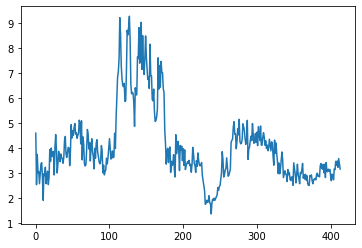

In [104]:
plt.plot(asymmetry_index_df['mouth'])
#plt.xlim(0,200)
#plt.xlim(350,650)

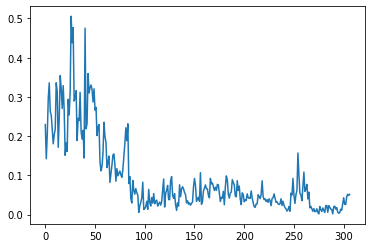

In [82]:
plt.plot(asymmetry_index_df['mouth'])
#plt.xlim(0,200)
#plt.xlim(350,650)

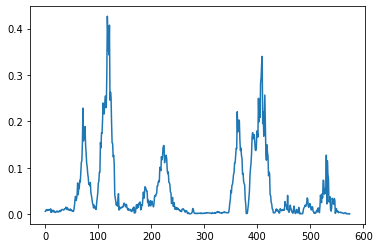

In [67]:
plt.plot(asymmetry_index_df['eyebrows'])


In [105]:
df = pd.DataFrame([i[0]['pose'] for i in detector.live_faces_objs],columns=['pitch','yaw','roll'])

<AxesSubplot:>

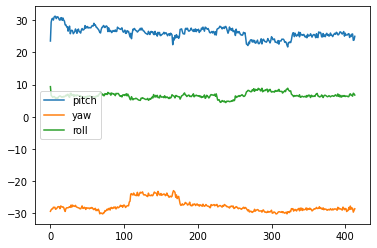

In [106]:
df.plot()

In [4]:
img=np.array(Image.open('data/dummy_data/samir/control_smile.jpeg'))

In [5]:
h,w,_ = img.shape
detector = FaceMeshDetector(frame_height=h,frame_width=w)
aligned_img,faces = detector.process(img)

In [6]:
face = faces[0]

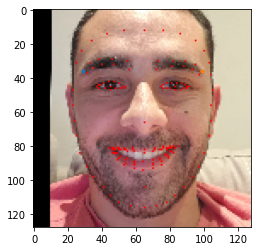

In [19]:
plt.imshow(detector.draw_faces(aligned_img,faces))
plt.scatter(*face['processed_landmarks']['left_eyebrow'][70],marker='.')
plt.scatter(*face['processed_landmarks']['right_eyebrow'][300],marker='.')

In [7]:
face['processed_landmarks']['left_eyebrow']

{65: array([46.83370213, 31.99275907]),
 66: array([46.08521813, 28.79292828]),
 70: array([29.01556459, 35.69952384]),
 105: array([38.41183809, 28.94976473]),
 107: array([54.75470117, 29.70589526]),
 46: array([31.22801882, 37.08112318]),
 52: array([39.81039379, 31.8889184 ]),
 53: array([34.70368668, 33.75308531]),
 55: array([56.0710845 , 35.00416618]),
 63: array([32.5689935 , 31.48344977])}

In [18]:
face['processed_landmarks']['right_eyebrow'][300]

array([98.80577751, 35.80695669])

In [8]:
roi = ROIExtractor(aligned_img,face['processed_landmarks'],debug=True)

In [7]:
import cv2
import mediapipe as mp
import numpy as np

from src.data.videosource import WebcamSource

from src.data.custom.face_geometry import (  # isort:skip
    PCF,
    get_metric_landmarks,
    procrustes_landmark_basis,
)


In [533]:

mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=3)

points_idx = [33, 263, 61, 291, 199]
points_idx = points_idx + [key for (key, val) in procrustes_landmark_basis]
points_idx = list(set(points_idx))
points_idx.sort()

# uncomment next line to use all points for PnP algorithm
# points_idx = list(range(0,468)); points_idx[0:2] = points_idx[0:2:-1];

frame_height, frame_width, channels = (720, 1280, 3)

# pseudo camera internals
focal_length = frame_width
center = (frame_width / 2, frame_height / 2)
camera_matrix = np.array(
    [[focal_length, 0, center[0]], [0, focal_length, center[1]], [0, 0, 1]],
    dtype="double",
)

dist_coeff = np.zeros((4, 1))


source = WebcamSource()

pcf = PCF(
    near=1,
    far=10000,
    frame_height=frame_height,
    frame_width=frame_width,
    fy=camera_matrix[1, 1],
)

with mp_face_mesh.FaceMesh(
    static_image_mode=False,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
) as face_mesh:

    for idx, (frame, frame_rgb) in enumerate(source):
        results = face_mesh.process(frame_rgb)
        multi_face_landmarks = results.multi_face_landmarks

        if multi_face_landmarks:
            face_landmarks = multi_face_landmarks[0]
            landmarks = np.array(
                [(lm.x, lm.y, lm.z) for lm in face_landmarks.landmark]
            )
            # print(landmarks.shape)
            landmarks = landmarks.T

            metric_landmarks, pose_transform_mat = get_metric_landmarks(
                landmarks.copy(), pcf
            )

            image_points = (
                landmarks[0:2, points_idx].T
                * np.array([frame_width, frame_height])[None, :]
            )
            model_points = metric_landmarks[0:3, points_idx].T

            # see here:
            # https://github.com/google/mediapipe/issues/1379#issuecomment-752534379
            pose_transform_mat[1:3, :] = -pose_transform_mat[1:3, :]
            mp_rotation_vector, _ = cv2.Rodrigues(pose_transform_mat[:3, :3])
            mp_translation_vector = pose_transform_mat[:3, 3, None]
            
            
            pose_transform_mat_inv = (cv2.Rodrigues(pose_transform_mat[:3, :3])-cv2.Rodrigues(pose_transform_mat[:3, :3]).T)/2
            mp_rotation_vector_inv, _ = cv2.Rodrigues(pose_transform_mat_inv)
            
            

            # Get rotational matrix
            rmat, jac = cv2.Rodrigues(mp_rotation_vector)

            # Get angles
            angles, mtxR, mtxQ, Qx, Qy, Qz = cv2.RQDecomp3x3(rmat)

            if False:
                # sanity check
                # get same result with solvePnP

                success, rotation_vector, translation_vector = cv2.solvePnP(
                    model_points,
                    image_points,
                    camera_matrix,
                    dist_coeff,
                    flags=cv2.cv2.SOLVEPNP_ITERATIVE,
                )

                np.testing.assert_almost_equal(mp_rotation_vector, rotation_vector)
                np.testing.assert_almost_equal(
                    mp_translation_vector, translation_vector
                )

            for face_landmarks in multi_face_landmarks:
                mp_drawing.draw_landmarks(
                    image=frame,
                    landmark_list=face_landmarks,
                    connections=mp_face_mesh.FACEMESH_CONTOURS,
                    landmark_drawing_spec=drawing_spec,
                    connection_drawing_spec=drawing_spec,
                )

            nose_tip = model_points[0]
            nose_tip_extended = 2.5 * model_points[0]
            (nose_pointer2D, jacobian) = cv2.projectPoints(
                np.array([nose_tip, nose_tip_extended]),
                mp_rotation_vector,
                mp_translation_vector,
                camera_matrix,
                dist_coeff,
            )

            nose_tip_2D, nose_tip_2D_extended = nose_pointer2D.squeeze().astype(int)
            frame = cv2.line(
                frame, nose_tip_2D, nose_tip_2D_extended, (255, 0, 0), 2
            )

        source.show(frame)


AttributeError: 'tuple' object has no attribute 'T'

In [190]:

mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=3)

points_idx = [33, 263, 61, 291, 199]
points_idx = points_idx + [key for (key, val) in procrustes_landmark_basis]
points_idx = list(set(points_idx))
points_idx.sort()

# uncomment next line to use all points for PnP algorithm
# points_idx = list(range(0,468)); points_idx[0:2] = points_idx[0:2:-1];

frame_height, frame_width, channels = (720, 1280, 3)

# pseudo camera internals
focal_length = frame_width
center = (frame_width / 2, frame_height / 2)
camera_matrix = np.array(
    [[focal_length, 0, center[0]], [0, focal_length, center[1]], [0, 0, 1]],
    dtype="double",
)

dist_coeff = np.zeros((4, 1))


source = WebcamSource()

pcf = PCF(
    near=1,
    far=10000,
    frame_height=frame_height,
    frame_width=frame_width,
    fy=camera_matrix[1, 1],
)

with mp_face_mesh.FaceMesh(
    static_image_mode=False,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    refine_landmarks=True
) as face_mesh:

    for idx, (frame, frame_rgb) in enumerate(source):
        results = face_mesh.process(frame_rgb)
        multi_face_landmarks = results.multi_face_landmarks

        if multi_face_landmarks:
            face_landmarks = multi_face_landmarks[0]
            landmarks = np.array(
                [(lm.x, lm.y, lm.z) for lm in face_landmarks.landmark]
            )
            # print(landmarks.shape)
            landmarks = landmarks.T[:,:468]

            metric_landmarks, pose_transform_mat = get_metric_landmarks(
                landmarks.copy(), pcf
            )

            image_points = (
                landmarks[0:2, points_idx].T
                * np.array([frame_width, frame_height])[None, :]
            )
            model_points = metric_landmarks[0:3, points_idx].T

            # see here:
            # https://github.com/google/mediapipe/issues/1379#issuecomment-752534379
            pose_transform_mat[1:3, :] = -pose_transform_mat[1:3, :]
            mp_rotation_vector, _ = cv2.Rodrigues(pose_transform_mat[:3, :3])
            mp_translation_vector = pose_transform_mat[:3, 3, None]            

            # Get rotational matrix
            rmat, jac = cv2.Rodrigues(mp_rotation_vector)

            # Get angles
            angles, mtxR, mtxQ, Qx, Qy, Qz = cv2.RQDecomp3x3(rmat)
            
            '''
            success, rotation_vector_pnp, translation_vector_pnp = cv2.solvePnP(
                landmarks.T[points_idx,:].T,
                landmarks.T[points_idx,:-1].T,
                camera_matrix,
                dist_coeff,
                flags=cv2.cv2.SOLVEPNP_ITERATIVE,
            )
            
            '''
            #rmat_pnp, jac_pnp = cv2.Rodrigues(rotation_vector_pnp)
                
            #angles_pnp, mtxR_pnp, _, _, _, _ = cv2.RQDecomp3x3(rmat_pnp)
                
            if False:
                # sanity check
                # get same result with solvePnP

                success, rotation_vector, translation_vector = cv2.solvePnP(
                    model_points,
                    image_points,
                    camera_matrix,
                    dist_coeff,
                    flags=cv2.cv2.SOLVEPNP_ITERATIVE,
                )

                np.testing.assert_almost_equal(mp_rotation_vector, rotation_vector)
                np.testing.assert_almost_equal(
                    mp_translation_vector, translation_vector
                )

            for face_landmarks in multi_face_landmarks:
                mp_drawing.draw_landmarks(
                    image=frame,
                    landmark_list=face_landmarks,
                    connections=mp_face_mesh.FACEMESH_CONTOURS,
                    landmark_drawing_spec=drawing_spec,
                    connection_drawing_spec=drawing_spec,
                )

            nose_tip = model_points[0]
            nose_tip_extended = 2.5 * model_points[0]
            (nose_pointer2D, jacobian) = cv2.projectPoints(
                np.array([nose_tip, nose_tip_extended]),
                mp_rotation_vector,
                mp_translation_vector,
                camera_matrix,
                dist_coeff,
            )

            nose_tip_2D, nose_tip_2D_extended = nose_pointer2D.squeeze().astype(int)
            frame = cv2.line(
                frame, nose_tip_2D, nose_tip_2D_extended, (255, 0, 0), 2
            )
            
            
            real_nose_tip = landmarks[:,4].T
            real_nose_tip_extended = 2.5 * landmarks[:,4].T
            (real_nose_pointer2D, real_jacobian) = cv2.projectPoints(
                np.array([real_nose_tip, real_nose_tip_extended]),
                -mp_rotation_vector,
                -mp_translation_vector,
                camera_matrix,
                dist_coeff,
            )
            
            real_nose_tip_2D, real_nose_tip_2D_extended = real_nose_pointer2D.squeeze().astype(int)
            
            real_nose_tip = landmarks[:,4].T
            frame = cv2.line(
                frame, real_nose_tip_2D, real_nose_tip_2D_extended, (255, 0, 0), 2
            )
            
            
            
            (landmarks_projected_2D, real_jacobian) = cv2.projectPoints(
                landmarks.T,
                -mp_rotation_vector,
                -mp_translation_vector,
                camera_matrix,
                dist_coeff,
            )
           
        source.show(frame)

KeyboardInterrupt: 

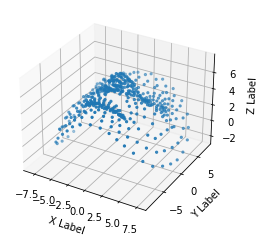

In [191]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(metric_landmarks.T[:,0],metric_landmarks.T[:,1],metric_landmarks.T[:,2],marker='.')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

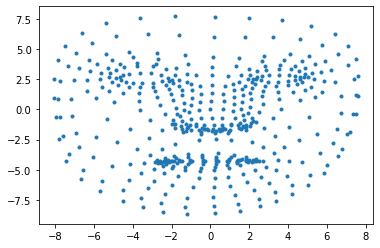

In [192]:
plt.scatter(metric_landmarks.T[:,0],metric_landmarks.T[:,1],marker='.')



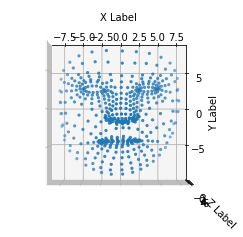

In [193]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(metric_landmarks.T[:,0],metric_landmarks.T[:,1],metric_landmarks.T[:,2],marker='.')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.view_init(90, -90)
plt.show()

In [194]:
pose_corrected_landmarks,_=cv2.projectPoints(
                                metric_landmarks.T,
                                np.array([[np.pi],[0],[0]]),
                                mp_translation_vector,
                                camera_matrix,
                                dist_coeff,
                            )

pose_corrected_landmarks = pose_corrected_landmarks.squeeze()

In [195]:
(*[pose_corrected_landmarks.max().round().astype(int)+50]*2,3)

(900, 900, 3)

In [196]:
np.degrees(mp_rotation_vector)

array([[158.48364496],
       [  3.16377601],
       [ 69.28295025]])

In [197]:
# Get rotational matrix
rmat, jac = cv2.Rodrigues(mp_rotation_vector)

# Get angles
angles, mtxR, mtxQ, Qx, Qy, Qz = cv2.RQDecomp3x3(rmat)

In [201]:
angles

(169.3683548147903, -46.788033175161566, 6.897422975873418)

In [199]:
x = np.sign(angles[0])*180-angles[0]
y = angles[1] 
z = -angles[2]

In [200]:
x,y,z

(10.631645185209692, -46.788033175161566, -6.897422975873418)

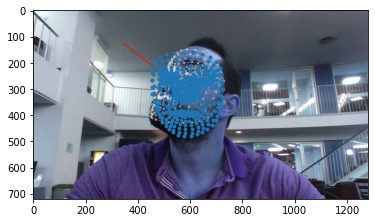

In [184]:
plt.imshow(frame)
plt.scatter(pose_corrected_landmarks[:,0],pose_corrected_landmarks[:,1],marker='.')

In [138]:
m,_=cv2.Rodrigues(np.array([[np.pi],
                            [0],
                            [0]]))
pose_corrected_3d_landmarks = (m@metric_landmarks+mp_translation_vector).T

In [139]:
landmarks.shape

(3, 468)

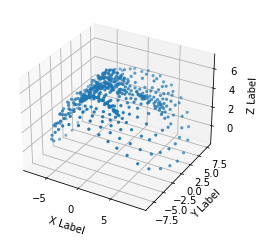

In [140]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(metric_landmarks.T[:,0],metric_landmarks.T[:,1],metric_landmarks.T[:,2],marker='.')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

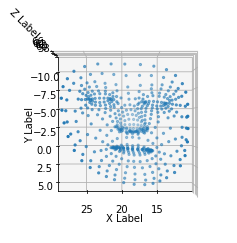

In [141]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pose_corrected_3d_landmarks[:,0],
           pose_corrected_3d_landmarks[:,1],
           pose_corrected_3d_landmarks[:,2],marker='.')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.view_init(90, 90)

plt.show()

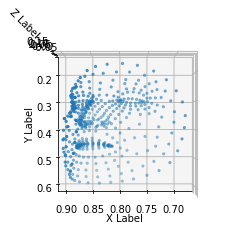

In [143]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(landmarks.T[:,0],
           landmarks.T[:,1],
           landmarks.T[:,2],marker='.')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.view_init(90, 90)

plt.show()

In [144]:
metric_landmarks.max(axis=1)-metric_landmarks.min(axis=1)

array([16.56081692, 15.84777146,  8.28236983])

In [145]:
pose_corrected_landmarks.max(axis=0)-pose_corrected_landmarks.min(axis=0)

array([325.62673016, 335.26253245])

In [146]:
pose_corrected_landmarks.shape

(468, 2)

In [147]:
p_image.max(axis=0),p_image.min(axis=0)

(array([718.15017773, 524.03552916,   1.        ]),
 array([436.7202227 , 207.85739254,   1.        ]))

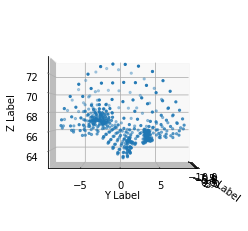

In [148]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(p_cam_coords.T[:,0],p_cam_coords.T[:,1],p_cam_coords.T[:,2],marker='.')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.view_init(0, 0)

plt.show()

In [32]:
p_image

array([[567.95473715, 421.91013361,   1.        ],
       [560.24756135, 379.6679759 ,   1.        ],
       [564.79215347, 392.82132906,   1.        ],
       ...,
       [585.61725825, 317.78909876,   1.        ],
       [658.6113125 , 310.27040061,   1.        ],
       [667.91786785, 301.10737956,   1.        ]])

In [31]:
a.squeeze()

array([[567.95473715, 421.91013361],
       [560.24756135, 379.6679759 ],
       [564.79215347, 392.82132906],
       [549.5814835 , 339.93120498],
       [561.16441105, 367.53144983],
       [562.83139558, 352.89814441],
       [561.91630689, 313.95962516],
       [482.91328019, 298.88979216],
       [559.84638916, 283.96126137],
       [557.69521559, 267.51018178],
       [556.54753111, 208.4334757 ],
       [568.91969223, 426.40288267],
       [569.4154673 , 429.33059425],
       [570.29232543, 430.60707885],
       [570.85086981, 430.78021014],
       [572.07876832, 435.02585883],
       [573.76828016, 439.70628668],
       [575.24580801, 444.18783021],
       [569.01774587, 465.39579554],
       [562.1930939 , 387.01947459],
       [553.60244672, 385.4182819 ],
       [439.76730048, 252.85760651],
       [514.05766179, 312.20159766],
       [502.87268384, 313.49957477],
       [492.80664552, 313.18252118],
       [485.34875363, 304.15300027],
       [524.15972016, 309.26919232],
 

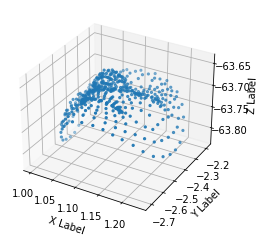

In [337]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

R=Rx(-np.degrees(mp_rotation_vector)[0])@Ry(-np.degrees(mp_rotation_vector)[1])@Rz(-np.degrees(mp_rotation_vector)[2])
landmakrs_pose_corrected = R@landmarks-mp_translation_vector
ax.scatter(landmakrs_pose_corrected.T[:,0],landmakrs_pose_corrected.T[:,1],landmakrs_pose_corrected.T[:,2],marker='.')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()